In [1]:
import matplotlib as mpl
mpl.rc('text', usetex=False)
mpl.rc('font', family='serif')
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)
mpl.rc('figure', figsize=(6, 4))
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.io as sio
from scipy import linalg

import firedrake as fd
import hydrogym as gym

fd.utils.ScalarType

dtype('float64')

In [2]:
mesh = 'sipp-lebedev'
flow = gym.flow.Cylinder(Re=50, mesh_name=mesh, h5_file=f'../output/{mesh}-steady.h5')
qB = flow.q.copy(deepcopy=True)
solver = gym.ts.IPCS(flow, dt=1e-2)
A, B = solver.linearize(qB)

In [3]:
evec_path = '../stability/output-split'
evec = np.load(f'{evec_path}/evec.npy')
evecH = np.load(f'{evec_path}/evecH.npy')

/home/firedrake/firedrake/lib/python3.8/site-packages/matplotlib_inline/config.py:75: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


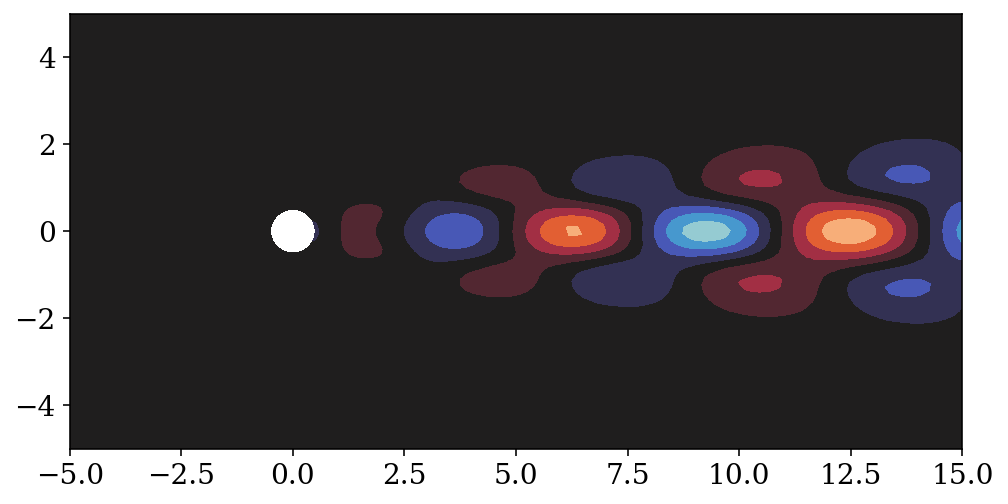

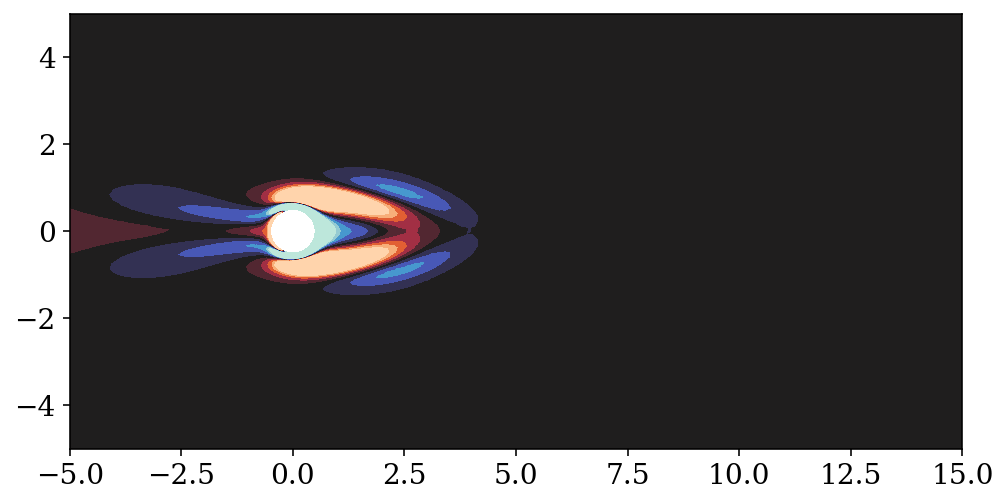

In [4]:
gym.utils.set_from_array(flow.q, np.real(evec[:, 0]))
vort = flow.vorticity()

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
levels = np.linspace(-0.02, 0.02, 10)
fd.tricontourf(vort, axes=ax, levels=levels, extend='both', 
               cmap=sns.color_palette("icefire", as_cmap=True))
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

gym.utils.set_from_array(flow.q, np.real(evecH[:, 0]))
vort = flow.vorticity()

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
levels = np.linspace(-0.02, 0.02, 10)
fd.tricontourf(vort, axes=ax, levels=levels, extend='both', 
               cmap=sns.color_palette("icefire", as_cmap=True))
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

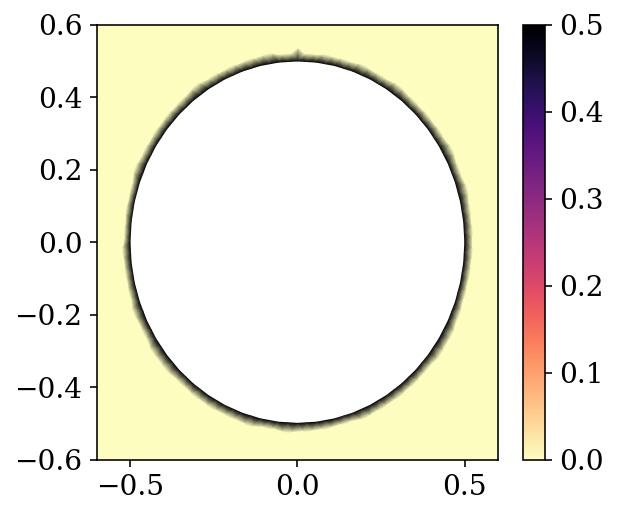

In [5]:
# Plot the control
B_fd = fd.Function(flow.mixed_space)
gym.utils.set_from_array(B_fd, B)

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4))
Bu, Bp = B_fd.split()
im = fd.tripcolor(Bu, axes=ax, cmap='magma_r')
plt.xlim([-0.6, 0.6])
plt.ylim([-0.6, 0.6])
plt.colorbar(im)

# Petrov-Galerkin projection

In [6]:
# Construct modal basis from real/imag parts
V = np.zeros((evec.shape[0], 2))
W = np.zeros_like(V)

V[:, 0] = np.real(evec[:, 0])
V[:, 1] = np.imag(evec[:, 0])
W[:, 0] = np.real(evecH[:, 0])
W[:, 1] = np.imag(evecH[:, 0])

M = flow.mass_matrix(backend='scipy')

In [7]:
# Construct action of "A" and "C" on basis vectors
N = evec.shape[0]
r = 2
y_dim = 2
A_on_basis_vecs = np.zeros((N, r))
C_on_basis_vecs = np.zeros((y_dim, r))
for i in range(r):
    A_on_basis_vecs[:, i] = A * V[:, i]

    gym.utils.set_from_array(flow.q, V[:, i])
    C_on_basis_vecs[:, i] = flow.collect_observations()

In [8]:
WV_inv = linalg.inv(W.T @ M @ V)
Ar = WV_inv @ (W.T @ M @ A_on_basis_vecs)
Br = WV_inv @ (W.T @ M @ B[:, None])
Cr = C_on_basis_vecs

In [9]:
dt_evals, _ = linalg.eig(Ar)
np.log(dt_evals)/1e-2

array([0.01691381+0.74786807j, 0.01691381-0.74786807j])

# LQG design

In [10]:
import control

### Feedback control

In [11]:
Q = np.eye(r)
R = 1e8
K, _, ctrl_evals = control.dlqr(Ar, Br, Q, R)

np.log(ctrl_evals)/1e-2

array([-0.01691412+0.74786807j, -0.01691412-0.74786807j])

In [12]:
Br

array([[-0.00210688],
       [ 0.01434925]])

In [13]:
K

array([[-0.00608037,  0.04625652]])

### Observer system

In [15]:
QN = 1e-6*np.eye(r)
RN = 1e-6*np.eye(y_dim)
GN = np.eye(r)

L, _, _ = control.dlqe(Ar, GN, Cr, QN, RN)

In [16]:
L

array([[-1.71846965e+00, -4.97745522e-04],
       [-6.91292783e-01, -2.23506287e-05]])

In [17]:
Cr

array([[-8.27261404e-04, -2.88735082e-04],
       [-2.43551520e-07, -2.66833188e-09]])

### Test on ROM

In [26]:
Tf = 100
dt = 1e-2
n_steps = int(Tf//dt)

x = np.zeros((r, n_steps))
y = np.zeros((y_dim, n_steps))
x_hat = np.zeros((r, n_steps))
q = 1e-2*V[:, 0]

# Initialize
P = WV_inv @ (W.T @ M)
x[:, 0] = P @ (1e-2*V[:, 0])
# x_hat[:, 0] = x[:, 0]

for i in range(1, n_steps):
    x[:, i] = Ar @ x[:, i-1]
    y[:, i] = Cr @ x[:, i]
    
    err = y[:, i] - Cr @ x_hat[:, i-1]
    x_hat[:, i] = Ar @ x_hat[:, i-1] + L @ err
    
    print(i, x[:, i], y[:, i], x_hat[:, i], np.linalg.norm(err))

1 [ 1.00014085e-02 -7.47988699e-05] [-8.25218221e-06 -2.43565867e-09] [1.41811259e-05 5.70467406e-06] 8.25218257177817e-06
2 [ 0.01000226 -0.00014962] [-8.23128161e-06 -2.43566586e-09] [2.83480116e-05 1.12803852e-05] 8.217903332365245e-06
3 [ 0.01000255 -0.00022446] [-8.20991324e-06 -2.43553673e-09] [4.24989710e-05 1.67269322e-05] 8.18320534572891e-06
4 [ 0.01000228 -0.00029931] [-8.18807815e-06 -2.43527125e-09] [5.66323202e-05 2.20441281e-05] 8.148091102618537e-06
5 [ 0.01000145 -0.00037416] [-8.16577740e-06 -2.43486938e-09] [7.07463783e-05 2.72318004e-05] 8.112563114026459e-06
6 [ 0.01000006 -0.00044903] [-8.14301207e-06 -2.43433110e-09] [8.48394671e-05 3.22897907e-05] 8.076623911020623e-06
7 [ 0.00999811 -0.00052389] [-8.11978329e-06 -2.43365639e-09] [9.89099113e-05 3.72179550e-05] 8.040276044576341e-06
8 [ 0.0099956  -0.00059875] [-8.09609220e-06 -2.43284524e-09] [1.12956039e-04 4.20161637e-05] 8.003522085407109e-06
9 [ 0.00999253 -0.0006736 ] [-8.07193997e-06 -2.43189765e-09] [1.2

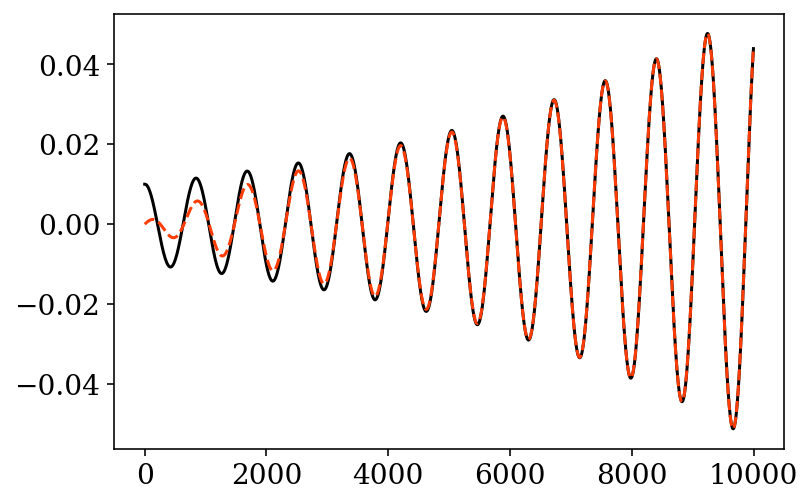

In [31]:
plt.plot(x[0, :], c='k')
plt.plot(x_hat[0, :], '--', c='xkcd:red orange')

In [50]:
# With control

Tf = 100
dt = 1e-2
n_steps = int(Tf//dt)

x = np.zeros((r, n_steps))
y = np.zeros((y_dim, n_steps))
x_hat = np.zeros((r, n_steps))
q = 1e-2*V[:, 0]

# Initialize
P = WV_inv @ (W.T @ M)
x[:, 0] = P @ (1e-2*V[:, 0])
# x_hat[:, 0] = x[:, 0]

for i in range(1, n_steps):
    x[:, i] = Ar @ x[:, i-1] - Br @ (K @ x_hat[:, i-1])
    y[:, i] = Cr @ x[:, i]
    
    err = y[:, i] - Cr @ x_hat[:, i-1]
    x_hat[:, i] = Ar @ x_hat[:, i-1] + L @ err
    
    print(i, x[:, i], y[:, i], x_hat[:, i], np.linalg.norm(err))

1 [ 1.00014085e-02 -7.47988699e-05] [-8.25218221e-06 -2.43565867e-09] [1.41811259e-05 5.70467406e-06] 8.25218257177817e-06
2 [ 0.01000226 -0.00014962] [-8.23128118e-06 -2.43566594e-09] [2.83480109e-05 1.12803849e-05] 8.217902905966959e-06
3 [ 0.01000255 -0.00022446] [-8.20991196e-06 -2.43553698e-09] [4.2498968e-05 1.6726931e-05] 8.183204064692896e-06
4 [ 0.01000228 -0.00029932] [-8.18807558e-06 -2.43527173e-09] [5.66323128e-05 2.20441252e-05] 8.148088537435181e-06
5 [ 0.01000145 -0.00037419] [-8.16577311e-06 -2.43487015e-09] [7.07463636e-05 2.72317945e-05] 8.112558834484645e-06
6 [ 0.01000006 -0.00044906] [-8.14300564e-06 -2.43433222e-09] [8.48394412e-05 3.22897805e-05] 8.076617486774029e-06
7 [ 0.00999811 -0.00052394] [-8.11977427e-06 -2.43365790e-09] [9.89098699e-05 3.72179388e-05] 8.040267045707241e-06
8 [ 0.00999561 -0.00059881] [-8.09608016e-06 -2.43284719e-09] [1.12955977e-04 4.20161395e-05] 8.003510082987643e-06
9 [ 0.00999254 -0.00067368] [-8.07192448e-06 -2.43190009e-09] [1.26

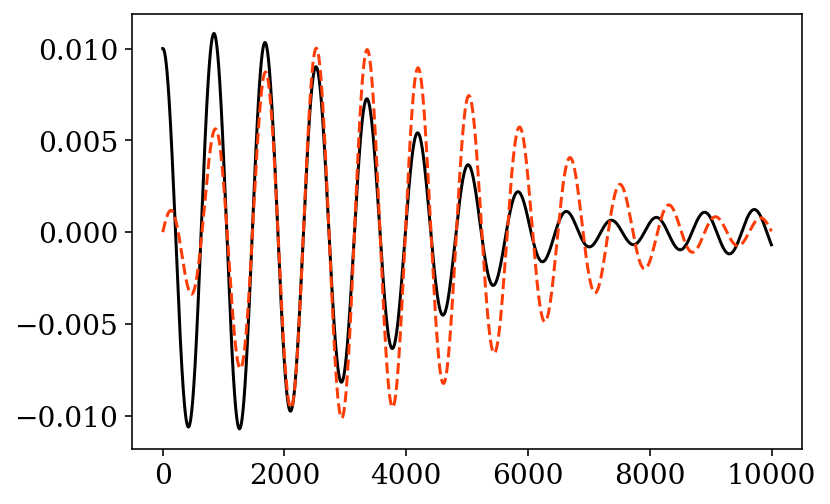

In [51]:
plt.plot(x[0, :], c='k')
plt.plot(x_hat[0, :], '--', c='xkcd:red orange')